<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/release/landlab_header.png"></a>

# Table of Contents
* [Introduction to Landlab: Creating a simple 2D scarp diffusion model](#Introduction-to-Landlab:-Creating-a-simple-2D-scarp-diffusion-model)
  * [Part 1: 1D version using numpy](#Part-1:-1D-version-using-numpy)
  * [Part 2: 2D version using Landlab's Model Grids](#Part-2:-2D-version-using-Landlab's-Model-Grids)
    * [(a) Explore the RasterModelGrid](#(a)-Explore-the-RasterModelGrid)
      * [Exercises for section 2a](#Exercises-for-section-2a)
    * [(b) Use the RasterModelGrid for 2D diffusion](#(b)-Use-the-RasterModelGrid-for-2D-diffusion)
      * [Exercises for section 2b](#Exercises-for-section-2b)
    * [(c) What's going on under the hood?](#(c)-What's-going-on-under-the-hood?)
      * [Exercises for section 2c](#Exercises-for-section-2c)
  * [Part 3: Hexagonal grid](#Part-3:-Hexagonal-grid)
      * [Exercises for section 3](#Exercises-for-section-3)
  * [Part 4: Landlab Components](#Part-4:-Landlab-Components)
      * [Exercises for section 4](#Exercises-for-section-4)
      * [SOLUTION (derivation)](#SOLUTION-(derivation))
        * [Derivation of the original governing equation](#Derivation-of-the-original-governing-equation)
        * [Steady state](#Steady-state)

# Introduction to Landlab: Creating a simple 2D scarp diffusion model

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>


This tutorial illustrates how you can use Landlab to construct a simple two-dimensional numerical model on a regular (raster) grid, using a simple forward-time, centered-space numerical scheme. The example is the erosional degradation of an earthquake fault scarp, and which evolves over time in response to the gradual downhill motion of soil. Here we use a simple "geomorphic diffusion" model for landform evolution, in which the downhill flow of soil is assumed to be proportional to the (downhill) gradient of the land surface multiplied by a transport coefficient.

We start by importing the [numpy](https://numpy.org) and [matplotlib](https://matplotlib.org) libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1: 1D version using numpy

This example uses a finite-volume numerical solution to the 2D diffusion equation. The 2D diffusion equation in this case is derived as follows. Continuity of mass states that:

$\frac{\partial z}{\partial t} = -\nabla \cdot \mathbf{q}_s$,

where $z$ is elevation, $t$ is time, the vector $\mathbf{q}_s$ is the volumetric soil transport rate per unit width, and $\nabla$ is the divergence operator (here in two dimensions). (Note that we have omitted a porosity factor here; its effect will be subsumed in the transport coefficient). The sediment flux vector depends on the slope gradient:

$\mathbf{q}_s = -D \nabla z$,

where $D$ is a transport-rate coefficient---sometimes called *hillslope diffusivity*---with dimensions of length squared per time. Combining the two, and assuming $D$ is uniform, we have a classical 2D diffusion equation:

$\frac{\partial z}{\partial t} = -\nabla^2 z$.

In this first example, we will create a our 1D domain in $x$ and $z$, and set a value for $D$.

This means that the equation we solve will be in 1D. 

$\frac{d z}{d t} = \frac{d q_s}{dx}$,

where 

$q_s = -D \frac{d z}{dx}$


In [2]:
dx = 1
x = np.arange(0, 100, dx, dtype=float)
z = np.zeros(x.shape, dtype=float)
D = 0.01

Next we must create our fault by uplifting some of the domain. We will increment all elements of `z` in which `x>50`.

In [3]:
z[x > 50] += 100

Finally, we will diffuse our fault for 1,000 years.

We will use a timestep with a [Courant–Friedrichs–Lewy condition](https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition) of $C_{cfl}=0.2$. This will keep our solution numerically stable. 

$C_{cfl} = \frac{\Delta t D}{\Delta x^2} = 0.2$

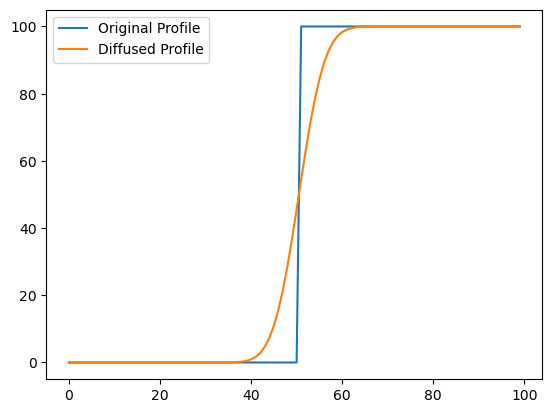

In [4]:
dt = 0.2 * dx * dx / D
total_time = 1e3
n_steps = int(total_time / dt)
z_orig = z.copy()
for _ in range(n_steps):
    qs = -D * np.diff(z) / dx
    dzdt = -np.diff(qs) / dx
    z[1:-1] += dzdt * dt

plt.plot(x, z_orig, label="Original Profile")
plt.plot(x, z, label="Diffused Profile")
plt.legend()

The prior example is pretty simple. If this was all you needed to do, you wouldn't need Landlab. 

But what if you wanted...

... to use the same diffusion model in 2D instead of 1D.

... to use an irregular grid (in 1 or 2D). 

... wanted to combine the diffusion model with a more complex model. 

... have a more complex model you want to use over and over again with different boundary conditions.

These are the sorts of problems that Landlab was designed to solve. 

In the next two sections we will introduce some of the core capabilities of Landlab. 

In Part 2 we will use the RasterModelGrid, fields, and a numerical utility for calculating flux divergence. 

In Part 3 we will use the HexagonalModelGrid. 

In Part 4 we will use the LinearDiffuser component. 

## Part 2: 2D version using Landlab's Model Grids

The Landlab model grids are data structures that represent the model domain (the variable `x` in our prior example). Here we will use `RasterModelGrid` which creates a grid with regularly spaced square grid elements. The RasterModelGrid knows how the elements are connected and how far apart they are.

Lets start by creating a RasterModelGrid class. First we need to import it. 

In [5]:
from landlab import RasterModelGrid


### (a) Explore the RasterModelGrid

Before we make a RasterModelGrid for our fault example, lets explore the Landlab model grid. 

Landlab considers the grid as a "dual" graph. Two sets of points, lines and polygons that represent 2D space. 

The first graph considers points called "nodes" that are connected by lines called "links". The area that surrounds each node is called a "cell".

First, the nodes

<Axes: xlabel='x', ylabel='y'>

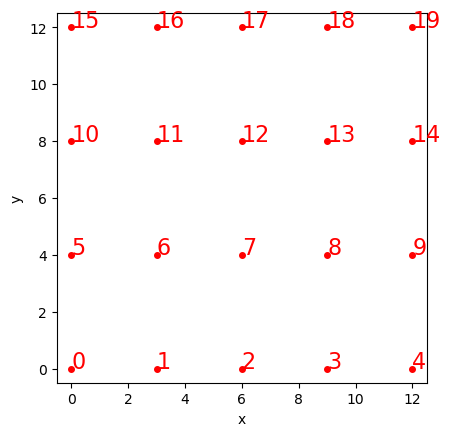

In [6]:
from landlab.plot.graph import plot_graph

grid = RasterModelGrid((4, 5), xy_spacing=(3, 4))
plot_graph(grid, at="node")

You can see that the nodes are points and they are numbered with unique IDs from lower left to upper right. 

Next the links

<Axes: xlabel='x', ylabel='y'>

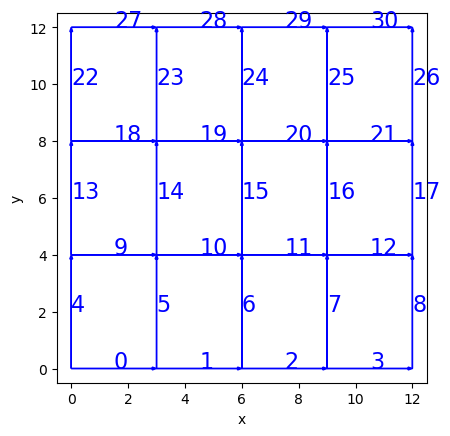

In [7]:
plot_graph(grid, at="link")

which are lines that connect the nodes and each have a unique ID number. 

And finally, the cells

<Axes: xlabel='x', ylabel='y'>

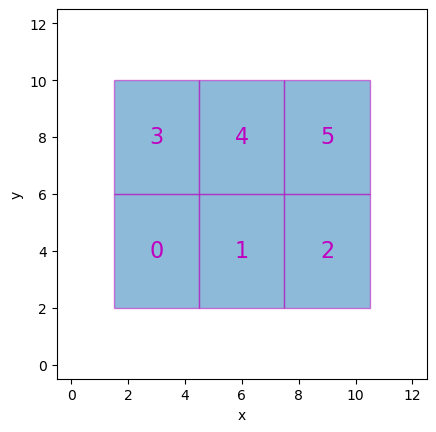

In [8]:
plot_graph(grid, at="cell")

which are polygons centered around the nodes. 

Landlab is a "dual" graph because it also keeps track of a second set of points, lines, and polygons ("corners", "faces", and "patches"). We will not focus on them further.

#### Exercises for section 2a

(2a.1) Create an instance of a `RasterModelGrid` with 5 rows and 7 columns, with a spacing between nodes of 10 units. Plot the node layout, and identify the ID number of the center-most node.

In [9]:
# (enter your solution to 2a.1 here)

<Axes: xlabel='x', ylabel='y'>

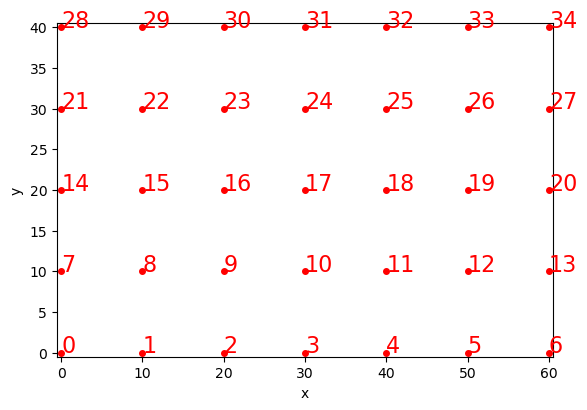

In [10]:
rmg = RasterModelGrid((5, 7), 10.0)
plot_graph(rmg, at="node")

(2a.2) Find the ID of the cell that contains this node.

In [11]:
# (enter your solution to 2a.2 here)

<Axes: xlabel='x', ylabel='y'>

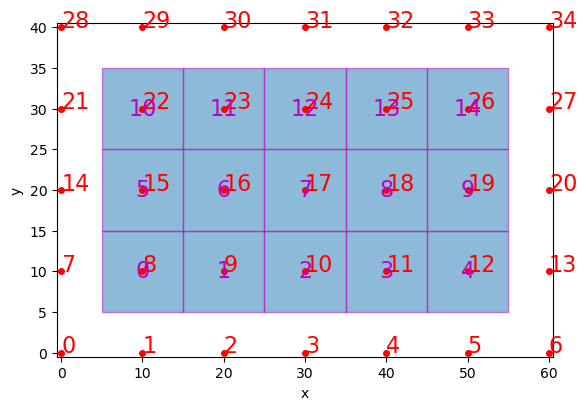

In [12]:
plot_graph(rmg, at="node,cell")

(2a.3) Find the ID of the horizontal link that connects to the last node on the right in the middle column.

In [13]:
# (enter your solution to 2a.3 here)

<Axes: xlabel='x', ylabel='y'>

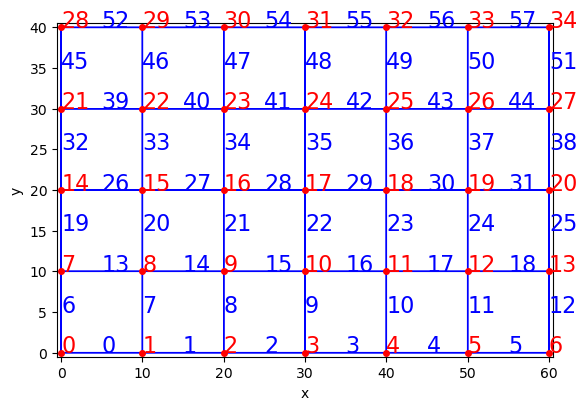

In [14]:
plot_graph(rmg, at="node,link")

### (b) Use the RasterModelGrid for 2D diffusion 

Lets continue by making a new grid that is bigger. We will use this for our next fault diffusion example.

The syntax in the next line says: create a new *RasterModelGrid* object called **mg**, with 25 rows, 40 columns, and a grid spacing of 10 m.

In [15]:
mg = RasterModelGrid((25, 40), 10.0)

Note the use of object-oriented programming here. `RasterModelGrid` is a class; `mg` is a particular instance of that class, and it contains all the data necessary to fully describe the topology and geometry of this particular grid.

Next we'll add a *data field* to the grid, to represent the elevation values at grid nodes. The "dot" syntax below indicates that we are calling a function (or *method*) that belongs to the *RasterModelGrid* class, and will act on data contained in **mg**. The arguments indicate that we want the data elements attached to grid nodes (rather than links, for example), and that we want to name this data field `topographic__elevation`. The `add_zeros` method returns the newly created NumPy array.

In [16]:
z = mg.add_zeros("topographic__elevation", at="node")

The above line of code creates space in memory to store 1,000 floating-point values, which will represent the elevation of the land surface at each of our 1,000 grid nodes.

Let's plot the positions of all the grid nodes. The nodes' *(x,y)* positions are stored in the arrays `mg.x_of_node` and `mg.y_of_node`, respectively.

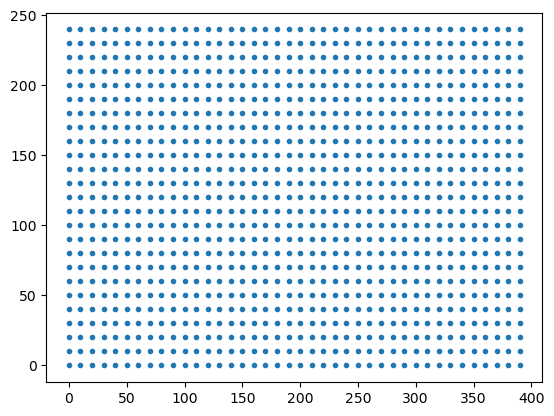

In [17]:
plt.plot(mg.x_of_node, mg.y_of_node, ".")

If we bothered to count, we'd see that there are indeed 1,000 grid nodes, and a corresponding number of `z` values:

In [18]:
len(z)

1000

Now for some tectonics. Let's say there's a fault trace that angles roughly east-northeast. We can describe the trace with the equation for a line. One trick here: by using `mg.x_of_node`, in the line of code below, we are calculating a *y* (i.e., north-south) position of the fault trace for each grid node---meaning that this is the *y* coordinate of the trace at the *x* coordinate of a given node.

In [19]:
fault_trace_y = 50.0 + 0.25 * mg.x_of_node

Here comes the earthquake. For all the nodes north of the fault (i.e., those with a *y* coordinate greater than the corresponding *y* coordinate of the fault trace), we'll add elevation equal to 10 meters plus a centimeter for every meter east along the grid (just to make it interesting):

In [20]:
z[mg.y_of_node > fault_trace_y] += (
    10.0 + 0.01 * mg.x_of_node[mg.y_of_node > fault_trace_y]
)

(A little bit of Python under the hood: the statement `mg.y_of_node > fault_trace_y` creates a 1000-element long boolean array; placing this within the index brackets will select only those array entries that correspond to `True` in the boolean array)

Let's look at our newly created initial topography using Landlab's *imshow_node_grid* plotting function (which we first need to import).

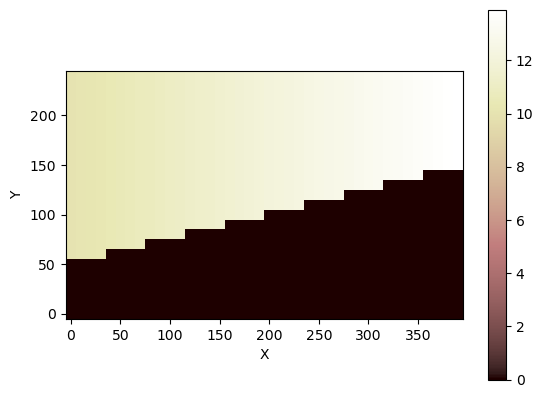

In [21]:
from landlab.plot.imshow import imshow_grid

imshow_grid(mg, "topographic__elevation")

To finish getting set up, we will define two parameters: the transport ("diffusivity") coefficient, `D`, and the time-step size, `dt`. (The latter is set using the Courant condition for a forward-time, centered-space finite-difference solution; you can find the explanation in most textbooks on numerical methods).

In [22]:
D = 0.01  # m2/yr transport coefficient
dt = 0.2 * mg.dx * mg.dx / D
dt

2000.0

Boundary conditions: for this example, we'll assume that the east and west sides are closed to flow of sediment, but that the north and south sides are open. (The order of the function arguments is east, north, west, south)

In [23]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

*A note on boundaries:* with a Landlab raster grid, all the perimeter nodes are boundary nodes. In this example, there are 24 + 24 + 39 + 39 = 126 boundary nodes. The previous line of code set those on the east and west edges to be **closed boundaries**, while those on the north and south are **open boundaries** (the default). All the remaining nodes are known as **core** nodes. In this example, there are 1000 - 126 = 874 core nodes:

In [24]:
len(mg.core_nodes)

874

One more thing before we run the time loop: we'll create an array to contain soil flux. In the function call below, the first argument tells Landlab that we want one value for each grid link, while the second argument provides a name for this data *field*:

In [25]:
qs = mg.add_zeros("sediment_flux", at="link")

And now for some landform evolution. We will loop through 25 iterations, representing 50,000 years. On each pass through the loop, we do the following:

1. Calculate, and store in the array `g`, the gradient between each neighboring pair of nodes. These calculations are done on **links**. The gradient value is a positive number when the gradient is "uphill" in the direction of the link, and negative when the gradient is "downhill" in the direction of the link. On a raster grid, link directions are always in the direction of increasing $x$ ("horizontal" links) or increasing $y$ ("vertical" links).

2. Calculate, and store in the array `qs`, the sediment flux between each adjacent pair of nodes by multiplying their gradient by the transport coefficient. We will only do this for the **active links** (those not connected to a closed boundary, and not connecting two boundary nodes of any type); others will remain as zero.

3. Calculate the resulting net flux at each node (positive=net outflux, negative=net influx). The negative of this array is the rate of change of elevation at each (core) node, so store it in a node array called `dzdt'.

4. Update the elevations for the new time step.

In [26]:
for i in range(25):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt

Let's look at how our fault scarp has evolved.

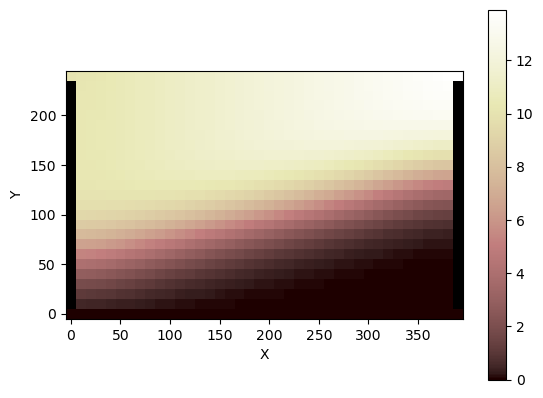

In [27]:
imshow_grid(mg, "topographic__elevation")

Notice that we have just created and run a 2D model of fault-scarp creation and diffusion with fewer than two dozen lines of code. How long would this have taken to write in C or Fortran?

While it was very very easy to write in 1D, writing this in 2D would mean we would have needed to keep track of the adjacency of the different parts of the grid. This is the primary problem that the Landlab grids are meant to solve. 

Think about how difficult this would be to hand code if the grid were irregular or hexagonal. In order to conserve mass and implement the differential equation you would need to know how nodes were conected, how long the links were, and how big each cell was.

We do such an example after the next section. 

#### Exercises for section 2b

(2b .1) Create an instance of a `RasterModelGrid` called `mygrid`, with 16 rows and 25 columns, with a spacing between nodes of 5 meters. Use the `plot` function in the `matplotlib` library to make a plot that shows the position of each node marked with a dot (hint: see the plt.plot() example above).

In [28]:
# (enter your solution to 2b.1 here)

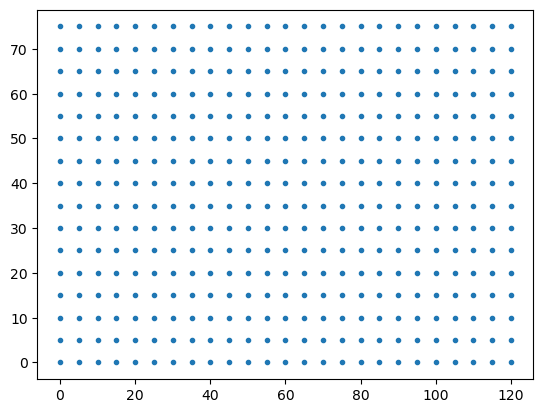

In [29]:
mygrid = RasterModelGrid((16, 25), xy_spacing=5.0)
plt.plot(mygrid.x_of_node, mygrid.y_of_node, ".")

(2b.2) Query the grid variables `number_of_nodes` and `number_of_core_nodes` to find out how many nodes are in your grid, and how many of them are core nodes.

In [30]:
# (enter your solution to 2b.2 here)

In [31]:
print(mygrid.number_of_nodes)
print(mygrid.number_of_core_nodes)

400
322


(2b.3) Add a new field to your grid, called `temperature` and attached to nodes. Have the initial values be all zero.

In [32]:
# (enter your solution to 2b.3 here)

In [33]:
temp = mygrid.add_zeros("temperature", at="node")

(2b.4) Change the temperature of nodes in the top (north) half of the grid to be 10 degrees C. Use the `imshow_grid` function to display a shaded image of the elevation field.

In [34]:
# (enter your solution to 2b.4 here)

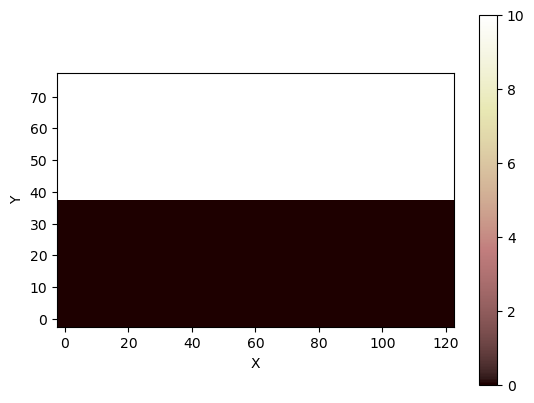

In [35]:
temp[mygrid.y_of_node >= 40.0] = 10.0
mygrid.imshow("temperature")

(2b.5) Use the grid function `set_closed_boundaries_at_grid_edges` to assign closed boundaries to the right and left sides of the grid.

In [36]:
# (enter your solution to 2b.5 here)

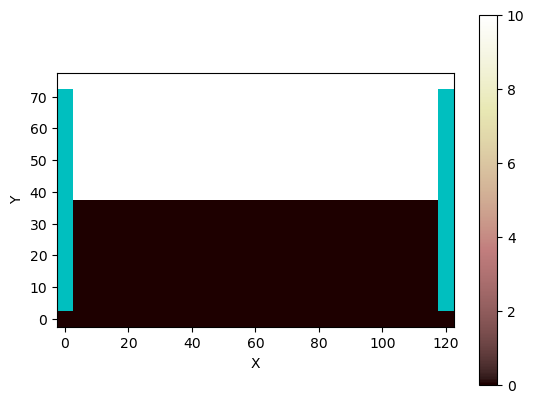

In [37]:
mygrid.set_closed_boundaries_at_grid_edges(True, False, True, False)
mygrid.imshow("temperature", color_for_closed="c")

(2b.6) Create a new field of zeros called `heat_flux` and attached to links. Using the `number_of_links` grid variable, verify that your new field array has the correct number of items. 

In [38]:
# (enter your solution to 2b.6 here)

In [39]:
Q = mygrid.add_zeros("heat_flux", at="link")
print(mygrid.number_of_links)
print(len(Q))

759
759


(2b.7) Use the `calc_grad_at_link` grid function to calculate the temperature gradients at all the links in the grid. Given the node spacing and the temperatures you assigned to the top versus bottom grid nodes, what do you expect the maximum temperature gradient to be? Print the values in the gradient array to verify that this is indeed the maximum temperature gradient.

In [40]:
# (enter your solution to 2b.7 here)

In [41]:
print("Expected max gradient is 2 C/m")
temp_grad = mygrid.calc_grad_at_link(temp)
print(temp_grad)

Expected max gradient is 2 C/m
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.

(2b.8) Back to hillslopes: Reset the values in the elevation field of the grid `mg` to zero. Then copy and paste the time loop above (i.e., the block in Section 2b that starts with `for i in range(25):`) below. Modify the last line to add uplift of the hillslope material at a rate `uplift_rate` = 0.0001 m/yr (hint: the amount of uplift in each iteration should be the uplift rate times the time-step duration). Then run the block and plot the resulting topography. Try experimenting with different uplift rates and different values of `D`.

In [42]:
# (enter your solution to 2b.8 here)

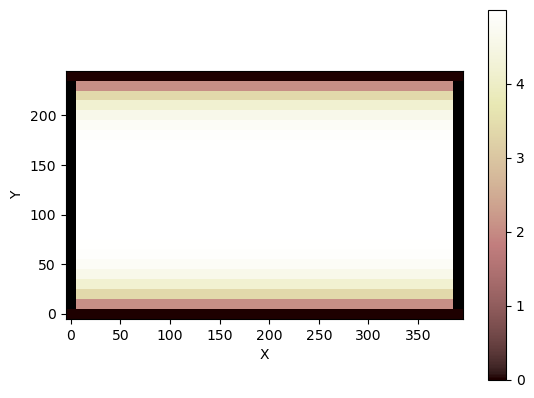

In [43]:
z[:] = 0.0
uplift_rate = 0.0001
for i in range(25):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += (dzdt[mg.core_nodes] + uplift_rate) * dt
mg.imshow(z)

### (c) What's going on under the hood?

This example uses a finite-volume numerical solution to the 2D diffusion equation. The 2D diffusion equation in this case is derived as follows. Continuity of mass states that:

$\frac{\partial z}{\partial t} = -\nabla \cdot \mathbf{q}_s$,

where $z$ is elevation, $t$ is time, the vector $\mathbf{q}_s$ is the volumetric soil transport rate per unit width, and $\nabla$ is the divergence operator (here in two dimensions). (Note that we have omitted a porosity factor here; its effect will be subsumed in the transport coefficient). The sediment flux vector depends on the slope gradient:

$\mathbf{q}_s = -D \nabla z$,

where $D$ is a transport-rate coefficient---sometimes called *hillslope diffusivity*---with dimensions of length squared per time. Combining the two, and assuming $D$ is uniform, we have a classical 2D diffusion equation:

$\frac{\partial z}{\partial t} = -\nabla^2 z$.

For the numerical solution, we discretize $z$ at a series of *nodes* on a grid. The example in this notebook uses a Landlab *RasterModelGrid*, in which every interior node sits inside a cell of width $\Delta x$, but we could alternatively have used any grid type that provides nodes, links, and cells.

The gradient and sediment flux vectors will be calculated at the *links* that connect each pair of adjacent nodes. These links correspond to the mid-points of the cell faces, and the values that we assign to links represent the gradients and fluxes, respectively, along the faces of the cells.

The flux divergence, $\nabla \mathbf{q}_s$, will be calculated by summing, for every cell, the total volume inflows and outflows at each cell face, and dividing the resulting sum by the cell area. Note that for a regular, rectilinear grid, as we use in this example, this finite-volume method is equivalent to a finite-difference method.

To advance the solution in time, we will use a simple explicit, forward-difference method. This solution scheme for a given node $i$ can be written:

$\frac{z_i^{t+1} - z_i^t}{\Delta t} = -\frac{1}{A_i} \sum\limits_{j=1}^{N_i} \delta (l_{ij}) q_s (l_{ij}) \lambda(l_{ij})$.

Here the superscripts refer to time steps, $\Delta t$ is time-step size, $q_s(l_{ij})$ is the sediment flux per width associated with the link that crosses the $j$-th face of the cell at node $i$, $\lambda(l_{ij})$ is the width of the cell face associated with that link ($=\Delta x$ for a regular uniform grid), and $N_i$ is the number of active links that connect to node $i$. The variable $\delta(l_{ij})$ contains either +1 or -1: it is +1 if link $l_{ij}$ is oriented away from the node (in which case positive flux would represent material leaving its cell), or -1 if instead the link "points" into the cell (in which case positive flux means material is entering).

To get the fluxes, we first calculate the *gradient*, $G$, at each link, $k$:

$G(k) = \frac{z(H_k) - z(T_k)}{L_k}$.

Here $H_k$ refers the *head node* associated with link $k$, $T_k$ is the *tail node* associated with link $k$. Each link has a direction: from the tail node to the head node. The length of link $k$ is $L_k$ (equal to $\Delta x$ is a regular uniform grid). What the above equation says is that the gradient in $z$ associated with each link is simply the difference in $z$ value between its two endpoint nodes, divided by the distance between them. The gradient is positive when the value at the head node (the "tip" of the link) is greater than the value at the tail node, and vice versa.

The calculation of gradients in $z$ at the links is accomplished with the `calc_grad_at_link` function. The sediment fluxes are then calculated by multiplying the link gradients by $-D$. Once the fluxes at links have been established, the `calc_flux_div_at_node` function performs the summation of fluxes.

#### Exercises for section 2c

(2c.1) Make a 3x3 `RasterModelGrid` called `tinygrid`, with a cell spacing of 2 m. Use the `plot_graph` function to display the nodes and their ID numbers.

In [44]:
# (enter your solution to 2c.1 here)

<Axes: xlabel='x', ylabel='y'>

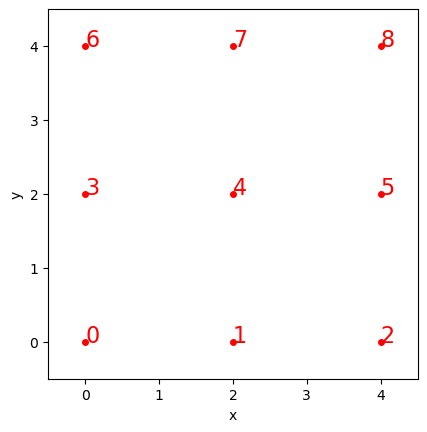

In [45]:
tinygrid = RasterModelGrid((3, 3), 2.0)
plot_graph(tinygrid, at="node")

(2c.2) Give your `tinygrid` a node field called `height` and set the height of the center-most node to 0.5. Use `imshow_grid` to display the height field.

In [46]:
# (enter your solution to 2c.2 here)

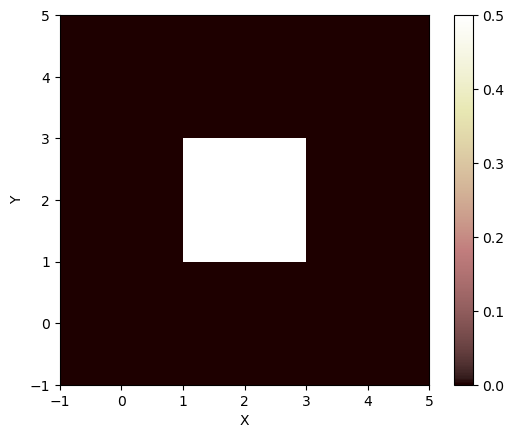

In [47]:
ht = tinygrid.add_zeros("height", at="node")
ht[4] = 0.5
imshow_grid(tinygrid, ht)

(2c.3) The grid should have 12 links (extra credit: verify this with `plot_graph`). When you compute gradients, which of these links will have non-zero gradients? What will the absolute value(s) of these gradients be? Which (if any) will have positive gradients and which negative? To codify your answers, make a 12-element numpy array that contains your predicted gradient value for each link.

In [48]:
# (enter your solution to 2c.3 here)

[ 0.    0.    0.    0.25  0.    0.25 -0.25  0.   -0.25  0.    0.    0.  ]


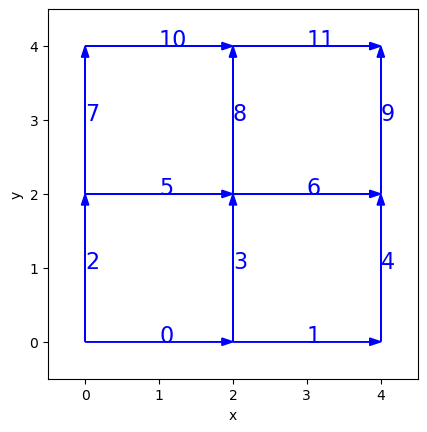

In [49]:
plot_graph(tinygrid, at="link")
pred_grad = np.array([0, 0, 0, 0.25, 0, 0.25, -0.25, 0, -0.25, 0, 0, 0])
print(pred_grad)

(2c.4) Test your prediction by running the `calc_grad_at_link` function on your tiny grid. Print the resulting array and compare it with your predictions.

In [50]:
# (enter your solution to 2c.4 here)

In [51]:
grad = tinygrid.calc_grad_at_link(ht)
print(grad)

[ 0.    0.    0.    0.25  0.    0.25 -0.25  0.   -0.25  0.    0.    0.  ]


(2c.5) Suppose the flux of soil per unit cell width is defined as -0.01 times the height gradient. What would the flux be at the those links that have non-zero gradients? Test your prediction by creating and printing a new array whose values are equal to -0.01 times the link-gradient values.

In [52]:
# (enter your solution to 2c.5 here)

In [53]:
flux = -0.01 * grad
print(flux)

[-0.     -0.     -0.     -0.0025 -0.     -0.0025  0.0025 -0.      0.0025
 -0.     -0.     -0.    ]


(2c.6) Consider the net soil accumulation or loss rate around the center-most node in your tiny grid (which is the only one that has a cell). The *divergence* of soil flux can be represented numerically as the sum of the total volumetric soil flux across each of the cell's four faces. What is the flux across each face? (Hint: multiply by face width) What do they add up to? Test your prediction by running the grid function `calc_flux_div_at_node` (hint: pass your unit flux array as the argument). What are the units of the divergence values returned by the `calc_flux_div_at_node` function?

In [54]:
# (enter your solution to 2c.6 here)

In [55]:
print("predicted div is 0 m/yr")
dqsdx = tinygrid.calc_flux_div_at_node(flux)
print(dqsdx)

predicted div is 0 m/yr
[ 0.     0.     0.     0.     0.005  0.     0.     0.     0.   ]


## Part 3: Hexagonal grid

Next we will use an non-raster Landlab grid.

We start by making a random set of points with x values between 0 and 400 and y values of 0 and 250. We then add zeros to our grid at a field called "topographic__elevation" and plot the node locations. 

Note that the syntax here is exactly the same as in the RasterModelGrid example (once the grid has been created).

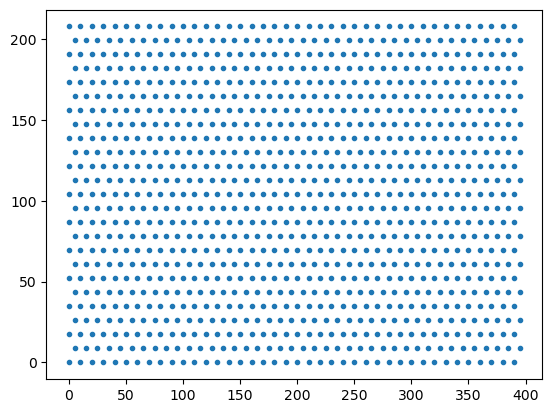

In [56]:
from landlab import HexModelGrid

mg = HexModelGrid((25, 40), 10, node_layout="rect")
z = mg.add_zeros("topographic__elevation", at="node")
plt.plot(mg.x_of_node, mg.y_of_node, ".")

Next we create our fault trace and uplift the hanging wall. 

We can plot just like we did with the RasterModelGrid. 

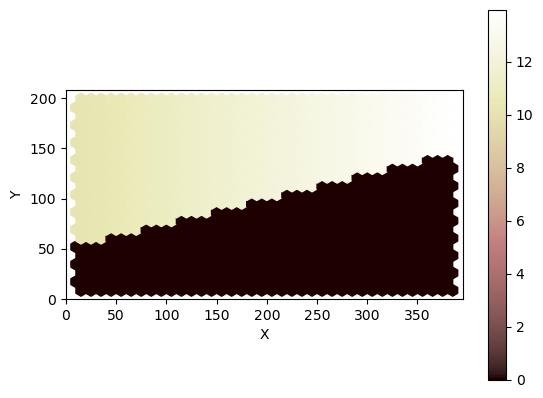

In [57]:
fault_trace_y = 50.0 + 0.25 * mg.x_of_node
z[mg.y_of_node > fault_trace_y] += (
    10.0 + 0.01 * mg.x_of_node[mg.y_of_node > fault_trace_y]
)
imshow_grid(mg, "topographic__elevation")

And we can use the same code as before to create a diffusion model!

Landlab supports multiple grid types. You can read more about them [here](https://landlab.readthedocs.io/en/latest/reference/grid/index.html).

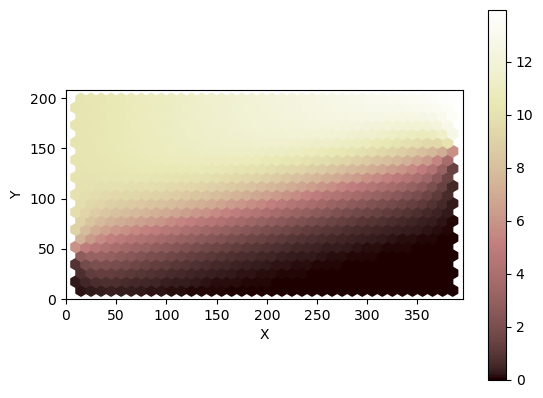

In [58]:
qs = mg.add_zeros("sediment_flux", at="link")
for i in range(25):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt
imshow_grid(mg, "topographic__elevation")

#### Exercises for section 3

(3.1-6) Repeat the exercises from section 2c, but this time using a hexagonal tiny grid called `tinyhex`. Your grid should have 7 nodes: one core node and 6 perimeter nodes. (Hints: use `node_layout = 'hex'`, and make a grid with 3 rows and 2 base-row columns.)

In [59]:
# (enter your solution to 3.1 here)

<Axes: xlabel='x', ylabel='y'>

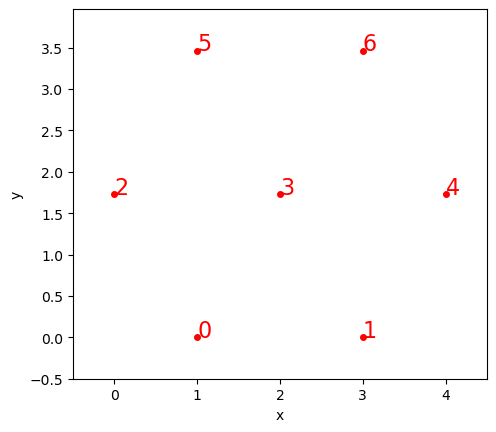

In [60]:
tinyhex = HexModelGrid((3, 2), 2.0)
plot_graph(tinyhex, at="node")

In [61]:
# (enter your solution to 3.2 here)

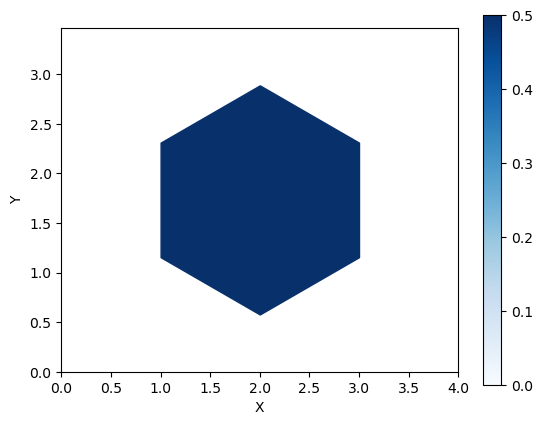

In [94]:
height = tinyhex.add_zeros("height", at="node")
height[3] = 0.5
tinyhex.imshow(height, cmap="Blues")

In [63]:
# (enter your solution to 3.3 here)

[ 0.    0.    0.25  0.25  0.    0.25 -0.25  0.   -0.25 -0.25  0.    0.  ]


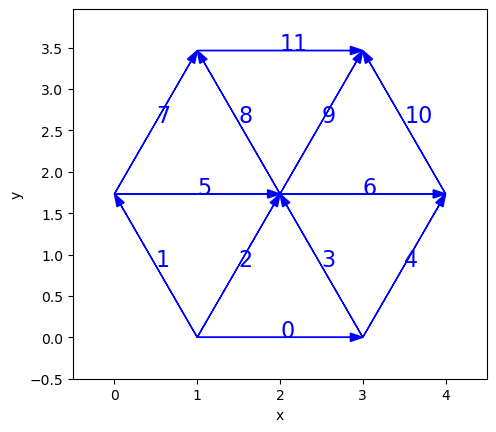

In [95]:
plot_graph(tinyhex, at="link")
pred_grad = np.array([0, 0, 0.25, 0.25, 0, 0.25, -0.25, 0, -0.25, -0.25, 0, 0])
print(pred_grad)

In [96]:
# (enter your solution to 3.4 here)

In [97]:
hexgrad = tinyhex.calc_grad_at_link(height)
print(hexgrad)

[ 0.    0.    0.25  0.25  0.    0.25 -0.25  0.   -0.25 -0.25  0.    0.  ]


In [98]:
# (enter your solution to 3.5 here)

In [99]:
hexflux = -0.01 * hexgrad
print(hexflux)

[-0.     -0.     -0.0025 -0.0025 -0.     -0.0025  0.0025 -0.      0.0025
  0.0025 -0.     -0.    ]


In [100]:
# (enter your solution to 3.6 here)

In [101]:
print(tinyhex.length_of_face)
print(tinyhex.area_of_cell)
total_outflux = 6 * 0.0025 * tinyhex.length_of_face[0]
divergence = total_outflux / tinyhex.area_of_cell[0]
print(total_outflux)
print(divergence)

[ 1.1547009  1.1547009  1.1547     1.1547     1.1547004  1.1547004]
[ 3.464101]
0.0173205135568
0.00500000247013


## Part 4: Landlab Components

Finally we will use a Landlab component, called the LinearDiffuser [link to its documentation](https://landlab.readthedocs.io/en/latest/reference/components/diffusion.html).

Landlab was designed to have many of the utilities like `calc_grad_at_link`, and `calc_flux_divergence_at_node` to help you make your own models. Sometimes, however, you may use such a model over and over and over. Then it is nice to be able to put it in its own python class with a standard interface. 

This is what a Landlab Component is. 

There is a whole [tutorial on components](../component_tutorial/component_tutorial.ipynb) and a [page on the User Guide](https://landlab.readthedocs.io/en/latest/user_guide/components.html). For now we will just show you what the prior example looks like if we use the LinearDiffuser. 

First we import it, set up the grid, and uplift our fault block. 

In [71]:
from landlab.components import LinearDiffuser

mg = HexModelGrid((25, 40), 10, node_layout="rect")
z = mg.add_zeros("topographic__elevation", at="node")
fault_trace_y = 50.0 + 0.25 * mg.x_of_node
z[mg.y_of_node > fault_trace_y] += (
    10.0 + 0.01 * mg.x_of_node[mg.y_of_node > fault_trace_y]
)

Next we instantiate a LinearDiffuser. We have to tell the component what value to use for the diffusivity. 

In [72]:
ld = LinearDiffuser(mg, linear_diffusivity=D)

Finally we run the component forward in time and plot. Like many Landlab components, the LinearDiffuser has a method called "run_one_step" that takes one input, the timestep dt. Calling this method runs the LinearDiffuser forward in time by an increment dt. 

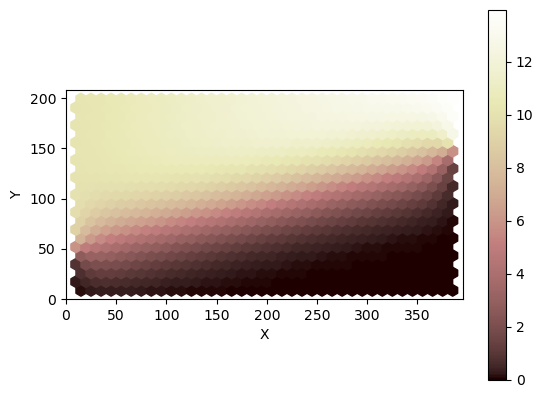

In [73]:
for i in range(25):
    ld.run_one_step(dt)
imshow_grid(mg, "topographic__elevation")

#### Exercises for section 4

(4.1) Repeat the steps above that instantiate and run a `LinearDiffuser` component, but this time give it a `RasterModelGrid`. Use `imshow_grid` to display the topography below.

In [74]:
# (enter your solution to 4.1 here)

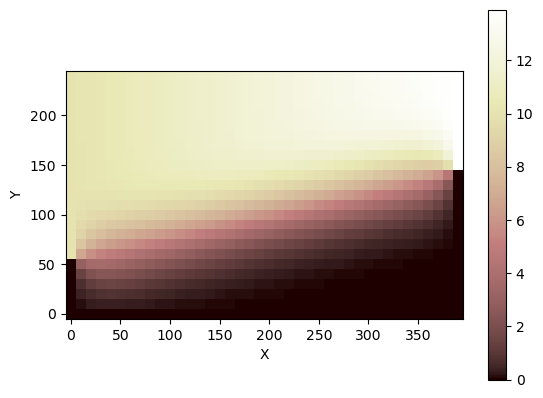

In [75]:
rmg = RasterModelGrid((25, 40), 10)
z = rmg.add_zeros("topographic__elevation", at="node")
fault_trace_y = 50.0 + 0.25 * rmg.x_of_node
z[rmg.y_of_node > fault_trace_y] += (
    10.0 + 0.01 * rmg.x_of_node[rmg.y_of_node > fault_trace_y]
)
ld = LinearDiffuser(rmg, linear_diffusivity=D)
for i in range(25):
    ld.run_one_step(dt)
imshow_grid(rmg, "topographic__elevation")

(4.2) Using either a raster or hex grid (your choice) with a `topographic__elevation` field that is initially all zeros, write a modified version of the loop that adds uplift to the core nodes each iteration, at a rate of 0.0001 m/yr. Run the model for enough time to accumulate 10 meters of uplift. Plot the terrain to verify that the land surface height never gets higher than 10 m. 

In [76]:
# (enter your solution to 4.2 here)

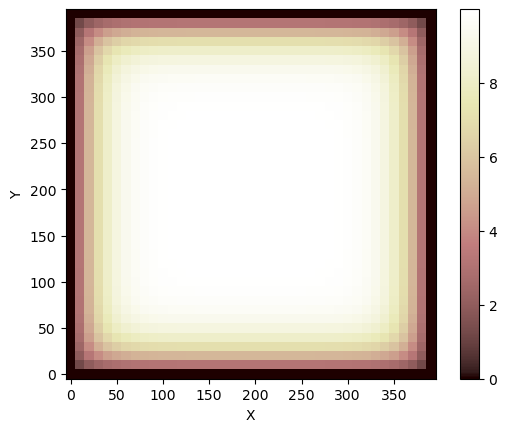

In [77]:
rmg = RasterModelGrid((40, 40), 10)  # while we're at it, make it a bit bigger
z = rmg.add_zeros("topographic__elevation", at="node")
ld = LinearDiffuser(rmg, linear_diffusivity=D)
for i in range(50):
    ld.run_one_step(dt)
    z[rmg.core_nodes] += dt * 0.0001
imshow_grid(rmg, "topographic__elevation")

(4.3) Now run the same model long enough that it reaches (or gets very close to) a dynamic equilibrium between uplift and erosion. What shape does the hillslope have?  

In [78]:
# (enter your solution to 4.3 here)

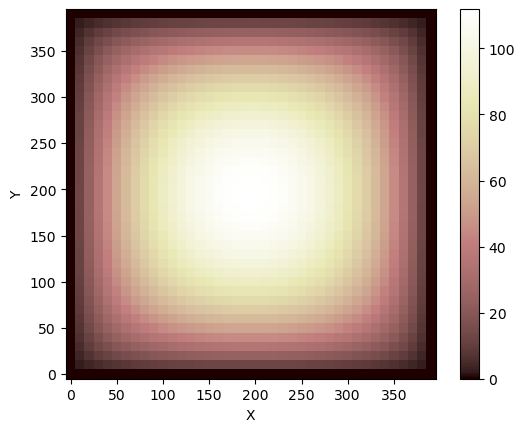

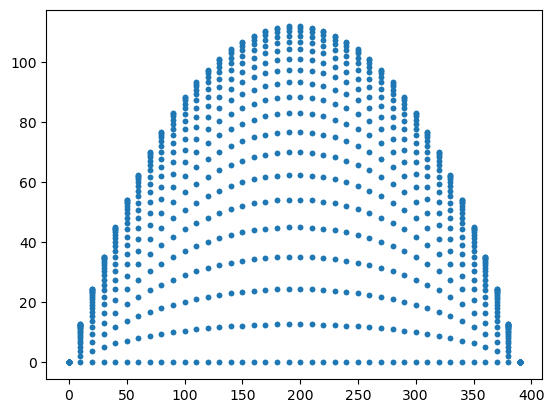

In [79]:
z[:] = 0.0
uplift_rate = 0.0001
for i in range(4000):
    ld.run_one_step(dt)
    z[rmg.core_nodes] += dt * uplift_rate
imshow_grid(rmg, "topographic__elevation")
plt.figure()
plt.plot(rmg.x_of_node, z, ".")

(BONUS CHALLENGE QUESTION) Derive an analytical solution for the cross-sectional shape of your steady-state hillslope. Plot this solution next to the actual model's cross-section.

#### SOLUTION (derivation)

##### Derivation of the original governing equation

(Note: you could just start with the governing equation and go from there, but we include this here for completeness).

Consider a topographic profile across a hillslope. The horizontal coordinate along the profile is $x$, measured from the left side of the profile (i.e., the base of the hill on the left side, where $x=0$). The horizontal coordinate perpendicular to the profile is $y$. Assume that at any time, the hillslope is perfectly symmetrical in the $y$ direction, and that there is no flow of soil in this direction.

Now consider a vertical column of soil somewhere along the profile. The left side of the column is at position $x$, and the right side is at position $x+\Delta x$, with $\Delta x$ being the width of the column in the $x$ direction. The width of the column in the $y$ direction is $W$. The height of the column, $z$, is also the height of the land surface at that location. Height is measured relative to the height of the base of the slope (in other words, $z(0) = 0$).

The total mass of soil inside the column, and above the slope base, is equal to the volume of soil material times its density times the fraction of space that it fills, which is 1 - porosity. Denoting soil particle density by $\rho$ and porosity by $\phi$, the soil mass in a column of height $h$ is

$m = (1-\phi ) \rho \Delta x W z$.

Conservation of mass dictates that the rate of change of mass equals the rate of mass inflow minus the rate of mass outflow. Assume that mass enters or leaves only by (1) soil creep, and (2) uplift of the hillslope material relative to the elevation of the hillslope base. The rate of the latter, in terms of length per time, will be denoted $U$. The rate of soil creep at a particular position $x$, in terms of bulk volume (including pores) per time per width, will be denoted $q_s(x)$. With this definition in mind, mass conservation dictates that:

$\frac{\partial (1-\phi ) \rho \Delta x W z}{\partial t} = \rho (1-\phi ) \Delta x W U + \rho (1-\phi ) q_s(x) - \rho (1-\phi ) q_s(x+\Delta x)$.

Assume that porosity and density are steady and uniform. Then,

$\frac{\partial z}{\partial t} = U + \frac{q_s(x) - q_s(x+\Delta x)}{\Delta x}$.

Factoring out -1 from the right-most term, and taking the limit as $\Delta x\rightarrow 0$, we get a differential equation that expresses conservation of mass for this situation:

$\frac{\partial z}{\partial t} = U - \frac{\partial q_s}{\partial x}$.

Next, substitute the soil-creep rate law

$q_s = -D \frac{\partial z}{\partial x}$,

to obtain

$\frac{\partial z}{\partial t} = U + D \frac{\partial^2 z}{\partial x^2}$.

##### Steady state

Steady means $dz/dt = 0$. If we go back to the mass conservation law a few steps ago and apply steady state, we find

$\frac{dq_s}{dx} = U$.

If you think of a hillslope that slopes down to the right, you can think of this as indicating that for every step you take to the right, you get another increment of incoming soil via uplift relative to baselevel. (Turns out it works the same way for a slope that angles down the left, but that's less obvious in the above math)

Integrate to get:

$q_s = Ux + C_1$, where $C_1$ is a constant of integration.

To evaluate the integration constant, let's assume the crest of the hill is right in the middle of the profile, at $x=L/2$, with $L$ being the total length of the profile. Net downslope soil flux will be zero at the crest (where the slope is zero), so for this location:

$q_s = 0 = UL/2 + C_1$, 

and therefore,

$C_1 = -UL/2$, 

and

$q_s = U (x - L/2)$.

Now substitute the creep law for $q_s$ and divide both sides by $-D$:

$\frac{dz}{dx} = \frac{U}{D} (L/2 - x)$.

Integrate:

$z = \frac{U}{D} (Lx/2 - x^2/2) + C_2$.

To evaluate $C_2$, recall that $z(0)=0$ (and also $z(L)=0$), so $C_2=0$. Hence, here's our analytical solution, which describes a parabola:

$\boxed{z = \frac{U}{2D} (Lx - x^2)}$.

In [80]:
# (enter your solution to the bonus challenge question here)

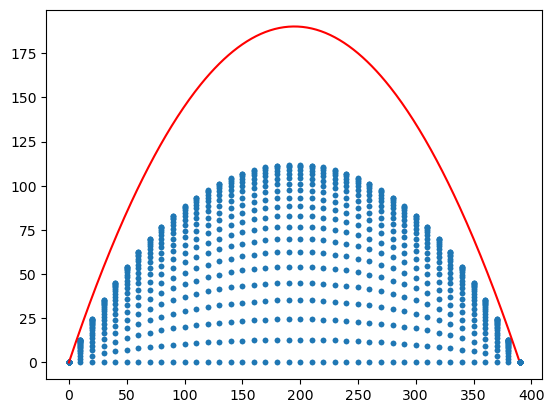

In [81]:
L = 390.0  # hillslope length, m
x_analytic = np.arange(0.0, L)
z_analytic = 0.5 * (uplift_rate / D) * (L * x_analytic - x_analytic * x_analytic)
plt.plot(rmg.x_of_node, z, ".")
plt.plot(x_analytic, z_analytic, "r")

Hey, hang on a minute, that's not a very good fit! What's going on? 

Turns out our 2D hillslope isn't as tall as the idealized 1D profile because of the boundary conditions: with soil free to flow east and west as well as north and south, the crest ends up lower than it would be if it were perfectly symmetrical in one direction.

So let's try re-running the numerical model, but this time with the north and south boundaries closed so that the hill shape becomes uniform in the $y$ direction:

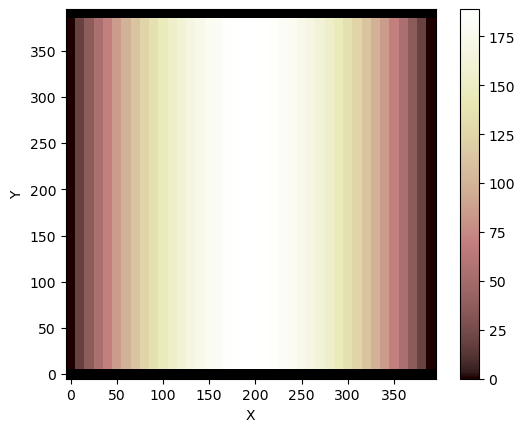

In [82]:
rmg = RasterModelGrid((40, 40), 10)
z = rmg.add_zeros("topographic__elevation", at="node")
rmg.set_closed_boundaries_at_grid_edges(False, True, False, True)  # closed on N and S
ld = LinearDiffuser(rmg, linear_diffusivity=D)
for _ in range(4000):
    ld.run_one_step(dt)
    z[rmg.core_nodes] += dt * uplift_rate
rmg.imshow("topographic__elevation")

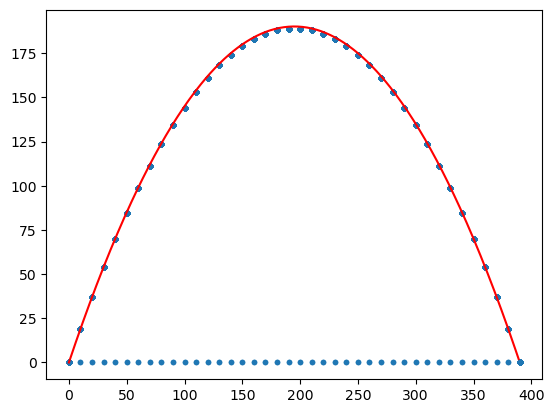

In [83]:
plt.plot(rmg.x_of_node, z, ".")
plt.plot(x_analytic, z_analytic, "r")

That's more like it!

Congratulations on making it to the end of this tutorial!

**Click here for more** <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>